In [1]:
# This notebook trains LSTM model on the preprocessed forecasted data

# forecast_features= [
#     "forecast_alberta_internal_load", 
#     "rolling_30day_avg_price", 
#     "solar_generation", 
#     "wind_generation", 
#     "temp_calgary", 
#     "temp_edmonton", 
#     "temp_fortmc", 
#     "ws_calgary",
#     "ws_edmonton", 
#     "ws_fortmc",
#     "datetime_", 
#     "hour_of_day", 
#     "day_of_week", 
#     "day_of_month", 
#     "week_of_month", 
#     "month", 
#     "year", 
#     "is_winter" 
# ]


# NVIDIA-SMI 535.183.01 
# CUDA Version: 10.1
# CUDNN Version: 
    #define CUDNN_MAJOR 7
    #define CUDNN_MINOR 6
    #define CUDNN_PATCHLEVEL 5
# Tensorflow Version: 2.2.0
# Python Version: 3.8.10

#### Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set pandas to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Suppress pandas performance warnings
import warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
from datetime import datetime, timedelta
import joblib

2025-03-24 17:00:20.097402: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 17:00:20.164684: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-24 17:00:20.166426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-24 17:00:22.805375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# check tf version
print('TensorFlow version:', tf.__version__)

#  Check if TensorFlow can access GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow is using GPU: {gpus}")
else:
    print("No GPU found, using CPU instead.")

TensorFlow version: 2.13.1
No GPU found, using CPU instead.


2025-03-24 17:00:27.713802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-24 17:00:27.917904: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


#### Data Loading

In [ ]:
# Load the data
# df2019 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2019/merged_df_2019_cleaned.csv')
# df2020 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2020/merged_df_2020_cleaned.csv')
# df2021 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2021/merged_df_2021_cleaned.csv')
# df2022 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2022/merged_df_2022_cleaned.csv')
# df2023 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2023/merged_df_2023_cleaned.csv')
# df2024 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2024/merged_df_2024_cleaned.csv')
df = pd.read_csv('/home/kevin/Downloads/BESS/Jobs/Retraining/data/raw/merged_df_cleaned.csv')

In [4]:
# Concatenate the data
# df2019
# df = pd.concat([df2020, df2021, df2022, df2023, df2024], axis=0, ignore_index=True)

In [5]:
df.shape

(24244, 69)

In [6]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2022-03-23 00:00:00,9146,9170,44.21,41.26,88.14,0.0,6.4,2.9,5.4,1543.927681,10.0,13,5,0,2,23,4,3,2022,1,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0
1,2022-03-23 01:00:00,9083,9075,47.55,47.55,88.09,0.0,8.9,3.5,5.6,1548.392596,7.0,13,3,1,2,23,4,3,2022,1,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0
2,2022-03-23 02:00:00,9020,9029,47.55,47.55,88.05,0.0,6.7,4.2,6.0,1523.838490,4.0,12,6,2,2,23,4,3,2022,1,47.55,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,9083.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0
3,2022-03-23 03:00:00,9007,9012,47.11,47.86,88.01,0.0,5.5,3.8,4.9,1498.064082,2.0,6,9,3,2,23,4,3,2022,1,47.55,47.55,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,9020.0,9083.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0
4,2022-03-23 04:00:00,9043,9023,46.95,47.03,87.98,0.0,4.6,2.0,4.5,1507.651054,2.0,6,10,4,2,23,4,3,2022,1,47.11,47.55,47.55,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,9007.0,9020.0,9083.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0


In [7]:
# remove actual AIL
df.drop(['alberta_internal_load'], inplace=True, axis=1)

# remove forecast_pool_price
df.drop(['forecast_pool_price'], inplace=True, axis=1)

In [8]:
# Check for missing values
df.isnull().sum().sort_values(ascending=False)

alberta_internal_load_lag_24      0
month                             0
pool_price_lag_12                 0
pool_price_lag_11                 0
pool_price_lag_10                 0
pool_price_lag_9                  0
pool_price_lag_8                  0
pool_price_lag_7                  0
pool_price_lag_6                  0
pool_price_lag_5                  0
pool_price_lag_4                  0
pool_price_lag_3                  0
pool_price_lag_2                  0
pool_price_lag_1                  0
is_winter                         0
year                              0
week_of_month                     0
pool_price_lag_14                 0
day_of_month                      0
day_of_week                       0
hour_of_day                       0
ws_fortmc                         0
ws_edmonton                       0
ws_calgary                        0
wind_generation                   0
temp_fortmc                       0
temp_edmonton                     0
temp_calgary                

/tmp/ipykernel_21873/3402150955.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['pool_price'], hist=True, kde=True)


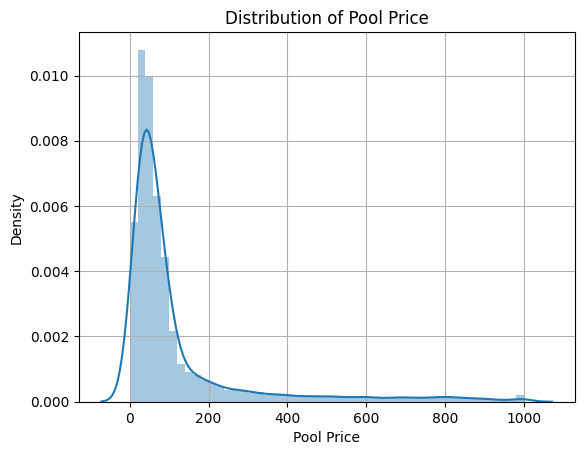

In [9]:
# Create a distribution plot of the 'pool_price' column
sns.distplot(df['pool_price'], hist=True, kde=True)

# Add labels and title
plt.xlabel('Pool Price')
plt.ylabel('Density')
plt.title('Distribution of Pool Price')

# Show the plot
plt.grid()
plt.show()

In [11]:
# data filter to remove outliers
# df = df[df['pool_price'] <=200]

#### Train-Test split

In [10]:
df.head()

,datetime_,forecast_alberta_internal_load,pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2022-03-23 00:00:00,9170,44.21,88.14,0.0,6.4,2.9,5.4,1543.927681,10.0,13,5,0,2,23,4,3,2022,1,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0
1,2022-03-23 01:00:00,9075,47.55,88.09,0.0,8.9,3.5,5.6,1548.392596,7.0,13,3,1,2,23,4,3,2022,1,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0
2,2022-03-23 02:00:00,9029,47.55,88.05,0.0,6.7,4.2,6.0,1523.838490,4.0,12,6,2,2,23,4,3,2022,1,47.55,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,9083.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0
3,2022-03-23 03:00:00,9012,47.11,88.01,0.0,5.5,3.8,4.9,1498.064082,2.0,6,9,3,2,23,4,3,2022,1,47.55,47.55,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,9020.0,9083.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0
4,2022-03-23 04:00:00,9023,46.95,87.98,0.0,4.6,2.0,4.5,1507.651054,2.0,6,10,4,2,23,4,3,2022,1,47.11,47.55,47.55,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,44.21,9007.0,9020.0,9083.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0,9146.0


In [11]:
# remove lag terms except 24 hours lag
# df.drop(columns = [col for col in df.columns if col.startswith('alberta_internal_load_lag') and col!='alberta_internal_load_lag_24'], inplace = True)
# df.drop(columns = [col for col in df.columns if col.startswith('pool_price_lag') and col!='pool_price_lag_24'], inplace = True)

In [ ]:
# Ensure 'datetime_' column is in datetime format
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Get the maximum date in the column
max_date = df['datetime_'].max()

# Calculate the first date of the last month
first_date_last_month = (max_date.replace(day=1) - timedelta(days=1)).replace(day=1)

# Format the date as 'yyyy-mm-dd'
first_date_last_month_str = first_date_last_month.strftime('%Y-%m-%d')

# print("First date of the last month:", first_date_last_month_str)

First date of the last month: 2024-11-01


In [13]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# Filter data for the first 11 months
train_data = df[df['datetime_'] < first_date_last_month_str]
test_data = df[df['datetime_'] >= first_date_last_month_str]

# Define independent variables (features) and target variable
X_train = train_data.drop(columns=['datetime_', 'pool_price'])
y_train = train_data['pool_price']
# Display the shapes of the training data
print(X_train.shape, y_train.shape)

# Define independent variables (features) and target variable
X_test = test_data.drop(columns=['datetime_', 'pool_price'])
y_test = test_data['pool_price']
# Display the shapes of the test data
print(X_test.shape, y_test.shape)

(22785, 65) (22785,)
(1459, 65) (1459,)


In [14]:
#Converting dataframe to numpy
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [15]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
#Reshaping the train and test data to pass into the LSTM layer
X_train = X_train.reshape((X_train.shape[0], 1, int(X_train.shape[1])))
X_test = X_test.reshape((X_test.shape[0], 1, int(X_test.shape[1])))

In [17]:
# Display the shapes of the training data
X_train.shape

(22785, 1, 65)

#### Model Training

In [18]:
#Baseline LSTM model
model = tf.keras.Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation=None))

# Compile the model
model.compile(optimizer='adam', loss='mae')

In [19]:
# display architecture of model shape of different layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               99328     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 109697 (428.50 KB)
Trainable params: 109697 (428.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=2, validation_split=0.2)

Epoch 1/20
143/143 - 4s - loss: 116.1750 - val_loss: 35.9255 - 4s/epoch - 31ms/step
Epoch 2/20
143/143 - 1s - loss: 66.7600 - val_loss: 27.3568 - 1s/epoch - 7ms/step
Epoch 3/20
143/143 - 1s - loss: 50.3511 - val_loss: 24.5787 - 1s/epoch - 8ms/step
Epoch 4/20
143/143 - 1s - loss: 46.7853 - val_loss: 22.8904 - 1s/epoch - 9ms/step
Epoch 5/20
143/143 - 1s - loss: 45.4131 - val_loss: 24.6478 - 1s/epoch - 9ms/step
Epoch 6/20
143/143 - 1s - loss: 44.5006 - val_loss: 24.3558 - 1s/epoch - 10ms/step
Epoch 7/20
143/143 - 1s - loss: 43.8776 - val_loss: 22.7446 - 1s/epoch - 8ms/step
Epoch 8/20
143/143 - 1s - loss: 43.3312 - val_loss: 24.2874 - 1s/epoch - 10ms/step
Epoch 9/20
143/143 - 1s - loss: 42.6249 - val_loss: 23.4090 - 1s/epoch - 8ms/step
Epoch 10/20
143/143 - 1s - loss: 42.3313 - val_loss: 23.8637 - 1s/epoch - 10ms/step
Epoch 11/20
143/143 - 1s - loss: 41.6430 - val_loss: 22.9452 - 1s/epoch - 8ms/step
Epoch 12/20
143/143 - 1s - loss: 41.4570 - val_loss: 22.7727 - 1s/epoch - 9ms/step
Epoch 13

#### Model Performance Check

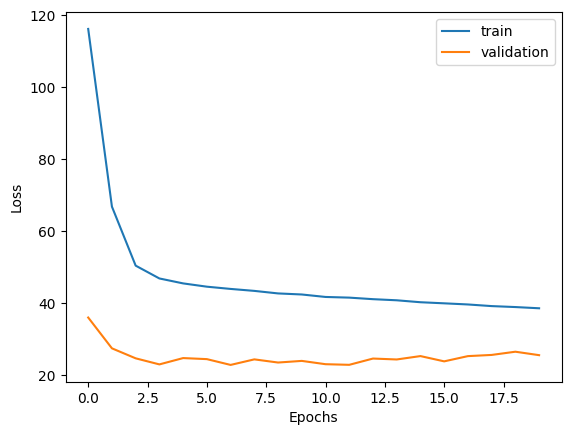

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
y_train_pred = model.predict(X_train)
y_train_pred = y_train_pred.reshape(-1, 1)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print('y_train shape:', y_train.shape)
print(f'Mean Absolute Error on the train set : {mae_train}')
print(f"R² Score train set: {r2_train}")

713/713 [==============================] - 3s 3ms/step
y_train shape: (22785,)
Mean Absolute Error on the train set : 35.088969814487214
R² Score train set: 0.8203819843963276


In [23]:
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.reshape(-1, 1)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print('y_test_pred shape:', y_test_pred.shape)
print(f'Mean Absolute Error on the test set : {mae_test}')
print(f"R² Score test set: {r2_test}")

 1/46 [..............................] - ETA: 1s

46/46 [==============================] - 0s 3ms/step
y_test_pred shape: (1459, 1)
Mean Absolute Error on the test set : 28.83015624890187
R² Score test set: 0.6386679161387896


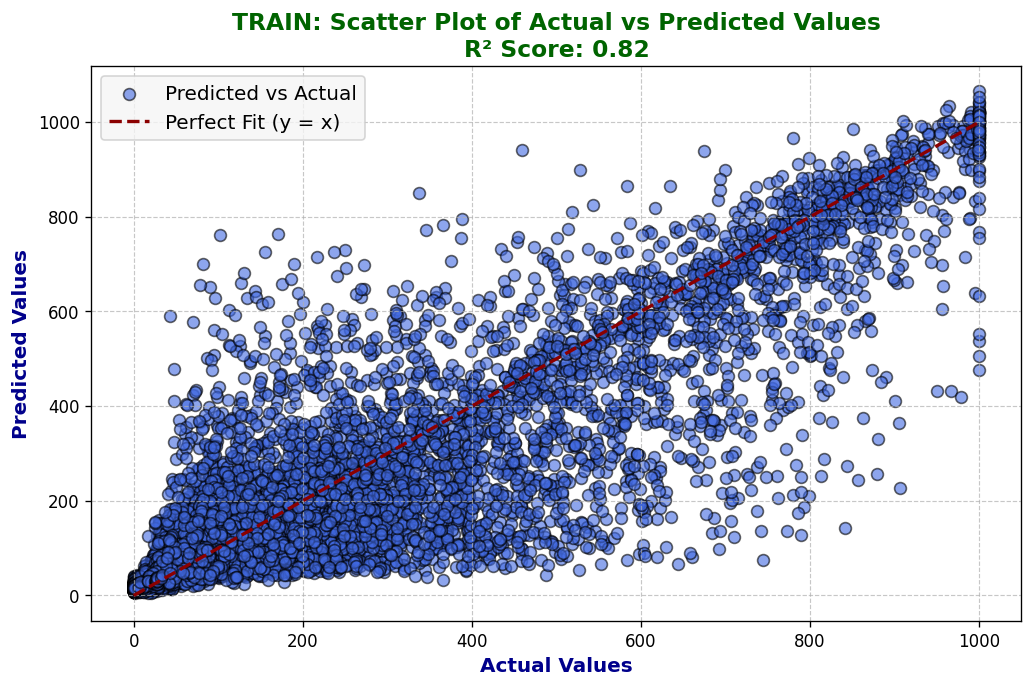

In [24]:
# Create a scatter plot with improved visibility
plt.figure(figsize=(10, 6), dpi=120)  # Higher DPI for sharper visualization

# Scatter plot with larger markers and better color contrast
plt.scatter(y_train, y_train_pred, alpha=0.6, color='royalblue', edgecolor='black', s=50, label='Predicted vs Actual')

# Add reference line (perfect predictions)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 
         color='darkred', linestyle='--', linewidth=2, label='Perfect Fit (y = x)')

# Improve labels and title for better readability
plt.xlabel('Actual Values', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Predicted Values', fontsize=12, fontweight='bold', color='darkblue')
plt.title(f'TRAIN: Scatter Plot of Actual vs Predicted Values\nR² Score: {r2_train:.2f}', 
          fontsize=14, fontweight='bold', color='darkgreen')

# Improve the legend for better clarity
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='whitesmoke')

# Customize grid for improved visibility
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Enhance tick visibility
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Show the plot
plt.show()


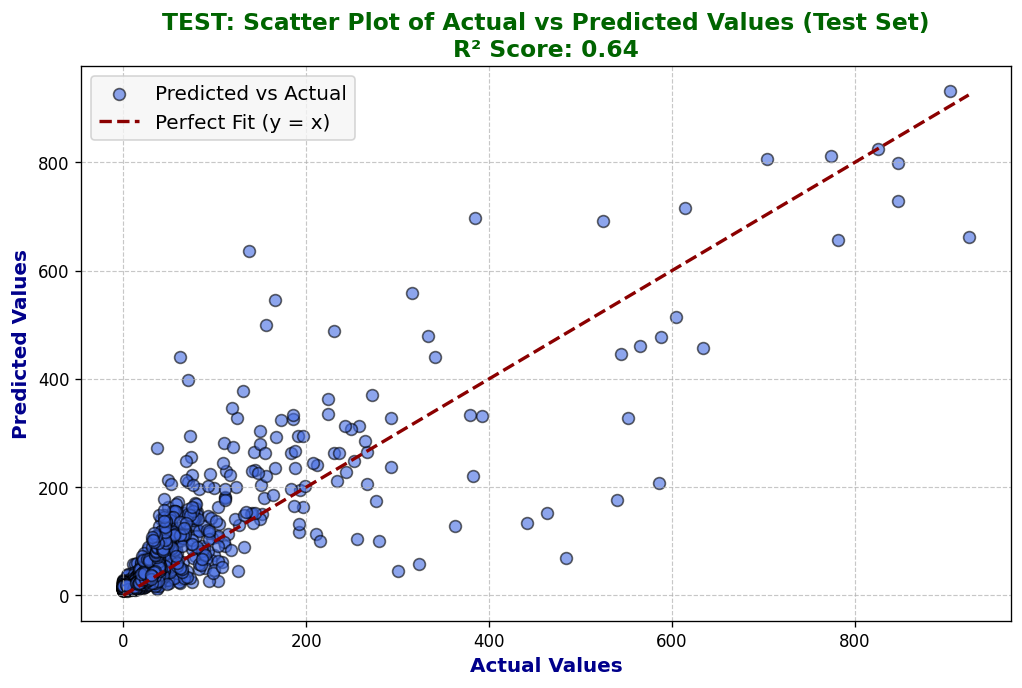

In [25]:
# Create a scatter plot for test data with improved visibility
plt.figure(figsize=(10, 6), dpi=120)  # Higher DPI for sharper visualization

# Scatter plot with larger markers and better color contrast
plt.scatter(y_test, y_test_pred, alpha=0.6, color='royalblue', edgecolor='black', s=50, label='Predicted vs Actual')

# Add reference line (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='darkred', linestyle='--', linewidth=2, label='Perfect Fit (y = x)')

# Improve labels and title for better readability
plt.xlabel('Actual Values', fontsize=12, fontweight='bold', color='darkblue')
plt.ylabel('Predicted Values', fontsize=12, fontweight='bold', color='darkblue')
plt.title(f'TEST: Scatter Plot of Actual vs Predicted Values (Test Set)\nR² Score: {r2_test:.2f}', 
          fontsize=14, fontweight='bold', color='darkgreen')

# Improve the legend for better clarity
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='whitesmoke')

# Customize grid for improved visibility
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)

# Enhance tick visibility
plt.xticks(fontsize=10, color='black')
plt.yticks(fontsize=10, color='black')

# Show the plot
plt.show()


In [ ]:
# # Create a dataframe of the actual and predicted values
# results_df = pd.DataFrame({'y_test':y_test, 'y_test_pred':y_test_pred.flatten()})
# results_df.head()

,y_test,y_test_pred
0,14.69,30.277470
1,16.23,29.698519
2,15.77,27.053698
3,13.85,26.254139
4,13.58,24.115364


In [ ]:
# terget_df = results_df[results_df['y_test'] <= 200]

# mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
# r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

# print('terget_df shape:', terget_df.shape)
# print(f'Mean Absolute Error on the test set : {mae}')
# print(f"R² Score test set: {r2}")

terget_df shape: (4203, 2)
Mean Absolute Error on the test set : 34.66420091885429
R² Score test set: -1.2083592759659032


In [ ]:
# terget_df = results_df[results_df['y_test'] > 200]

# mae = mean_absolute_error(terget_df.y_test, terget_df.y_test_pred)
# r2 = r2_score(terget_df.y_test, terget_df.y_test_pred)

# print('terget_df shape:', terget_df.shape)
# print(f'Mean Absolute Error on the test set : {mae}')
# print(f"R² Score test set: {r2}")

terget_df shape: (216, 2)
Mean Absolute Error on the test set : 148.44289876655296
R² Score test set: 0.3434053599764778


#### Store Model Artifacts

In [ ]:
# Save the trained model
def save_model(model, save_path):
    model.save(save_path)
    print(f"Model saved to {save_path}")

save_path = f"/home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/lstm_model_{datetime.now().strftime('%Y%m%d')}.h5"
save_model(model, save_path)

model saved at /home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/lstm_model_20250324.h5
Model saved to /home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/lstm_model_20250324.h5


In [28]:
# Save the scaler
def save_scaler(scaler, save_path):
    joblib.dump(scaler, save_path)
    print(f"Scaler saved to {save_path}")

save_path = f"/home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/scaler_{datetime.now().strftime('%Y%m%d')}.pkl"
print('scaler saved at {save_path}')
save_scaler(scaler, save_path)

scaler saved at {save_path}
Scaler saved to /home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/scaler_20250324.pkl


#### Model Inferencing

In [ ]:
# load inference data
# inference_data = pd.read_csv('/home/kevin/Downloads/BESS/Jobs/Inferencing/data/raw/merged_df_cleaned.csv')

In [ ]:
# # Load the saved model
# def load_model(save_path):
#     model = tf.keras.models.load_model(save_path)
#     print(f"Model loaded from {save_path}")
#     return model

# save_path = f"/home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/lstm_model_{datetime.now().strftime('%Y%m%d')}.h5"

# # load trained model
# model = load_model(save_path)

Model loaded from /home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/lstm_model_20250320.h5


In [ ]:
# # Load the scaler
# def load_scaler(save_path):
#     scaler = joblib.load(save_path)
#     print(f"Scaler loaded from {save_path}")
#     return scaler

# save_path = f"/home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/scaler_{datetime.now().strftime('%Y%m%d')}.pkl"

# scaler = load_scaler(save_path)

Scaler loaded from /home/kevin/Downloads/BESS/Jobs/Retraining/artifacts/scaler_20250320.pkl


In [ ]:
# # data transformation
# X_inference = inference_data.drop(columns=['datetime_'])
# X_inference = scaler.transform(X_inference)
# X_inference = X_inference.reshape((X_inference.shape[0], 1, int(X_inference.shape[1])))

# # make predictions
# y_inference_pred = model.predict(X_inference)
# y_inference_pred = y_inference_pred.reshape(-1, 1)
# y_inference_pred

array([[40.84008 ],
       [40.898457],
       [50.041996],
       [55.528152],
       [55.33215 ],
       [52.632683],
       [47.74548 ],
       [43.815575],
       [37.34431 ],
       [35.550556],
       [35.31981 ],
       [35.70145 ],
       [37.394756],
       [40.98639 ],
       [45.748547],
       [47.275097],
       [40.63331 ],
       [30.939926],
       [28.114107],
       [29.324333],
       [30.616375],
       [30.73483 ],
       [30.499538],
       [29.014   ]], dtype=float32)

In [ ]:
# # save the predictions
# pred_df_new = pd.DataFrame()
# pred_df_new['datetime_'] = inference_data['datetime_']
# pred_df_new['predicted_pool_price'] = y_inference_pred

# # load the existing predictions
# try:
#     pred_df = pd.read_csv('/home/kevin/Downloads/BESS/Jobs/Inferencing/data/predictions/pred_df.csv')
# except:
#     pred_df = pd.DataFrame()

# # concatenate the new predictions with the existing predictions
# pred_df = pd.concat([pred_df, pred_df_new], axis=0, ignore_index=True)
# # drop duplicates
# pred_df = pred_df.drop_duplicates(subset=['datetime_'], keep='last')
# # sort the dataframe by datetime
# pred_df = pred_df.sort_values(by='datetime_', ascending=True)
# # reset the index
# pred_df = pred_df.reset_index(drop=True)
# # save the predictions
# pred_df.to_csv('/home/kevin/Downloads/BESS/Jobs/Inferencing/data/predictions/pred_df.csv', index=False)

: 